In [ ]:
# Import necessary libraries

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix # not using it possibly
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
# Checking the encoding type of the dataset
import chardet
with open('/content/drive/MyDrive/Colab Notebooks/LP 5/imdb.csv', 'rb') as f:
    result = chardet.detect(f.read(10000))

print(result['encoding'])

# Loading the dataset and removing unnecessary columns
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/LP 5/imdb.csv', encoding=result['encoding'])

df = df.drop(['Unnamed: 0', 'type', 'file'], axis=1)
df.head()

MacRoman


,review,label
0,Once again Mr. Costner has dragged out a movie...,neg
1,This is an example of why the majority of acti...,neg
2,"First of all I hate those moronic rappers, who...",neg
3,Not even the Beatles could write songs everyon...,neg
4,Brass pictures (movies is not a fitting word f...,neg


In [ ]:
# Setting Parameters
vocab_size = 10000
max_len = 200

In [ ]:
# Removing irrelevant labels, only keeping 'pos' and 'neg' label values
print(df['label'].unique())
df = df[df['label'].isin(['pos', 'neg'])]
# print(df['label'].unique())
df['label'] = df['label'].map({'pos': 1, 'neg': 0}).astype(int)
df.head()



['neg' 'pos' 'unsup']


,review,label
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [ ]:
# split the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(df['review'], df['label'], test_size=0.2, random_state=42)

In [ ]:
# Defining a tokenizer to convert words/text into number sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

In [ ]:
# Padding the sequences to strictly have a max length of 200 words, no more, no less
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_seq, maxlen=max_len, padding='post')

In [ ]:
# defining the neural network
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), # new
    tf.keras.layers.GlobalMaxPooling1D(),   # new
    tf.keras.layers.Dense(32, activation='relu'),   # old but half the neurons
    tf.keras.layers.Dropout(0.5),           # better generalization
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping to regularize the model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# training the model
history = model.fit(x_train_pad, y_train, epochs=20, batch_size=128, validation_data=(x_test_pad, y_test), callbacks=early_stop)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 189s 584ms/step - accuracy: 0.6962 - loss: 0.5545 - val_accuracy: 0.8749 - val_loss: 0.3004
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 198s 572ms/step - accuracy: 0.9016 - loss: 0.2608 - val_accuracy: 0.8857 - val_loss: 0.2692
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 575ms/step - accuracy: 0.9273 - loss: 0.2007 - val_accuracy: 0.8856 - val_loss: 0.2830
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 200s 571ms/step - accuracy: 0.9533 - loss: 0.1430 - val_accuracy: 0.8868 - val_loss: 0.2870


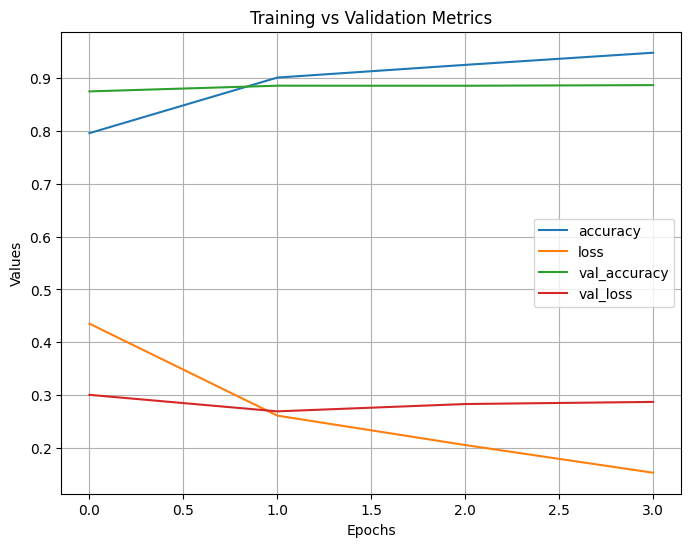

In [ ]:
# Plot the accuracy vs loss
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.title("Training vs Validation Metrics")
plt.xlabel("Epochs")
plt.ylabel("Values")
plt.grid(True)
plt.show()

In [ ]:
# evaluating the model on test data
loss, accuracy = model.evaluate(x_test_pad, y_test)
print(f"Test Accuracy: {(100 * accuracy):.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.8861 - loss: 0.2615
Test Accuracy: 88.57%


In [ ]:
# making predictions on test reviews
y_pred = model.predict(x_test_pad).flatten()
y_pred = (y_pred > 0.5).astype(int)

313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      5055
           1       0.89      0.88      0.88      4945

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

